In [2]:
import re
import numpy as np
import pandas as pd
import sklearn
import matplotlib
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
import nltk
# sklearn
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from collections import Counter
from PIL import Image
from wordcloud import WordCloud,ImageColorGenerator
import urllib
import requests

In [3]:
print(sklearn.__version__)
print(matplotlib.__version__)
print(np.__version__)
print(pd.__version__)
print(nltk.__version__)

0.23.1
3.1.3
1.18.1
1.0.1
3.7


In [4]:
file_name='dataset.csv'
data = pd.read_csv(file_name, sep = ',',names = ['text','username','location'])
data.shape

(131563, 3)

In [5]:
data.head()

,text,username,location
0,RT @tsum_africa: In response to the current #C...,PaulABarter,Singapore
1,RT @FemAdesina: No presidential broadcast on C...,Abdulazizmento2,port Harcourt
2,Covid-19 Outbreak in Nigeria Is Just One of Af...,Ricardo_Gardel,"Tinton Falls, NJ"
3,RT @ChangeOrg_India: Walking miles without foo...,ahumanenough,NaN
4,RT @GhulamABilour: I have been tested positive...,tormakhay_s,"Sexi, Peru"


In [6]:
#dropping Empty Rows
data=data[(data['location'].notnull())] 
#Resetting index
data = data.sample(frac=1).reset_index(drop=True)
#removing Clip tweets
data['len']=data["text"].str.len()                          
df1= data[(data['len'] <=137)]
df2=data[(data['len'] >=150)]
#concatinating two Dataframes
data=pd.concat([df1,df2])  
#resetting Index
data = data.sample(frac=1).reset_index(drop=True)       

In [7]:
data.shape

(35482, 4)

In [8]:
data.head()

,text,username,location,len
0,@FirhanM87 We have just launched a new Covid-1...,easyJet,Europe,166
1,"The Fed is far more lethal than COVID-19… $2,0...",StanleyECook,"Athens, Al 35611",183
2,🚨 @FreelandsF + @an_artnews \n\nare supportin...,myrunwaygroup,London,255
3,RT @staronline: Covid-19: Several students tes...,Inadiasyikin,Malaysia-Singapura-Indonesia,136
4,A COVID-19 patient admitted to the Ahmedabad C...,VargheseGeorge8,Jaipur,217


In [9]:
#Data Preprocessing 
#In the above-given problem statement before training the model, we have performed various pre-processing steps on the 
#dataset that mainly dealt with removing stopwords, removing emojis. The text document is then converted into the lowercase
#for better generalization.

#Subsequently, the punctuations were cleaned and removed thereby reducing the unnecessary noise from the dataset.
#After that, we have also removed the repeating characters from the words along with removing the URLs as they do not 
#have any significant importance.

#function to remove pattern 
def remove_pattern(input_txt, pattern):                                          
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

# removing RT @x from tweets:
# removing  @xxx from tweets:
# removing URL links http://xxx

def clean_tweets(lst):
    lst = np.vectorize(remove_pattern)(lst, "\r")                                  
    lst = np.vectorize(remove_pattern)(lst, "\n")
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")                         
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")                             
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")            
    return lst

In [10]:
#Cleaned Tweets are kept in separate coloumn
data['clean']= clean_tweets(data['text'])   

In [11]:
data.head()

,text,username,location,len,clean
0,@FirhanM87 We have just launched a new Covid-1...,easyJet,Europe,166,We have just launched a new Covid-19 Help Hub...
1,"The Fed is far more lethal than COVID-19… $2,0...",StanleyECook,"Athens, Al 35611",183,"The Fed is far more lethal than COVID-19… $2,0..."
2,🚨 @FreelandsF + @an_artnews \n\nare supportin...,myrunwaygroup,London,255,🚨 + are supporting freelance creatives &amp...
3,RT @staronline: Covid-19: Several students tes...,Inadiasyikin,Malaysia-Singapura-Indonesia,136,Covid-19: Several students test positive afte...
4,A COVID-19 patient admitted to the Ahmedabad C...,VargheseGeorge8,Jaipur,217,A COVID-19 patient admitted to the Ahmedabad C...


In [12]:
#removing Repetative Words
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data['clean'] = data['clean'].apply(lambda x: cleaning_repeating_char(x))

In [13]:
data.tail()

,text,username,location,len,clean
35477,Gov't streams £84m into UK COVID-19 vaccines r...,projectsdoctor,Worldwide,101,Gov't streams £84m into UK COVID19 vaccines re...
35478,@SiobhanByrne99 Thanks for your message. Our C...,easyJet,Europe,253,Thanks for your message. Our Covid19 Help Hub...
35479,RT @DilanTheVillain: i can hear the DJs now “i...,MidouMir,"Paris, France",93,i can hear the DJs now “if you survived COVID...
35480,RT @ManilaPIO: LIVE | Mayor's City Address: CO...,_CYchology,MNL,89,"LIVE | Mayor's City Address: CODE COVID19, Da..."
35481,@minmsme Respected sir\n\n We have a ngo.And r...,GreenWorldWelf1,"Sonarpur, Kolkata",280,Respected sir We have a ngo.And recently we a...


In [14]:
#clearing Punctuation Marks

import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

data['clean']= data['clean'].apply(lambda x: cleaning_punctuations(x))
data.tail()

,text,username,location,len,clean
35477,Gov't streams £84m into UK COVID-19 vaccines r...,projectsdoctor,Worldwide,101,Govt streams £84m into UK COVID19 vaccines res...
35478,@SiobhanByrne99 Thanks for your message. Our C...,easyJet,Europe,253,Thanks for your message Our Covid19 Help Hub ...
35479,RT @DilanTheVillain: i can hear the DJs now “i...,MidouMir,"Paris, France",93,i can hear the DJs now “if you survived COVID...
35480,RT @ManilaPIO: LIVE | Mayor's City Address: CO...,_CYchology,MNL,89,LIVE Mayors City Address CODE COVID19 Day 68
35481,@minmsme Respected sir\n\n We have a ngo.And r...,GreenWorldWelf1,"Sonarpur, Kolkata",280,Respected sir We have a ngoAnd recently we ar...


In [15]:
#Defining set containing all stopwords in English.

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s',
                'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [16]:
#Cleaning and removing the above stop words list from the tweet text

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data['cleant'] = data['clean'].apply(lambda text: cleaning_stopwords(text))
data['cleant'].tail()

35477       Govt streams £84m UK COVID19 vaccines research
35478    Thanks message Our Covid19 Help Hub provides i...
35479      hear DJs “if survived COVID19 make mf’n noise”😂
35480         LIVE Mayors City Address CODE COVID19 Day 68
35481    Respected sir We ngoAnd recently ready product...
Name: cleant, dtype: object

In [17]:
pd.options.display.max_rows=4000

In [18]:
#Tokenization
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
data['text_Token']=data['cleant'].apply(tokenizer.tokenize)
data['text_Token'].head()

0    [w, w, w]
1          [w]
2          [w]
3           []
4           []
Name: text_Token, dtype: object

In [19]:
#Stemming(reducing the words to their derived stems) for better Result..
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
data['text_Token']= data['text_Token'].apply(lambda x: stemming_on_text(x))
data['text_Token'].head()

0    [w, w, w]
1          [w]
2          [w]
3           []
4           []
Name: text_Token, dtype: object

In [20]:
data.tail()

,text,username,location,len,clean,cleant,text_Token
35477,Gov't streams £84m into UK COVID-19 vaccines r...,projectsdoctor,Worldwide,101,Govt streams £84m into UK COVID19 vaccines res...,Govt streams £84m UK COVID19 vaccines research,[]
35478,@SiobhanByrne99 Thanks for your message. Our C...,easyJet,Europe,253,Thanks for your message Our Covid19 Help Hub ...,Thanks message Our Covid19 Help Hub provides i...,[w]
35479,RT @DilanTheVillain: i can hear the DJs now “i...,MidouMir,"Paris, France",93,i can hear the DJs now “if you survived COVID...,hear DJs “if survived COVID19 make mf’n noise”😂,[]
35480,RT @ManilaPIO: LIVE | Mayor's City Address: CO...,_CYchology,MNL,89,LIVE Mayors City Address CODE COVID19 Day 68,LIVE Mayors City Address CODE COVID19 Day 68,[]
35481,@minmsme Respected sir\n\n We have a ngo.And r...,GreenWorldWelf1,"Sonarpur, Kolkata",280,Respected sir We have a ngoAnd recently we ar...,Respected sir We ngoAnd recently ready product...,[w]


In [21]:
#vaderSentiment is used to tag tweets as positive, negative or neutral

analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(text):
    score = analyser.polarity_scores(text)
    if score['compound'] >= 0.05 :
        return 2
    elif (score['compound'] > -0.05) and (score['compound'] < 0.05) : 
        return 1 
    else :
        return 0

In [22]:
 #Each tweet goes throug vader function and gets labeled.
    
sentiments_using_vader = data.clean.apply(lambda text: sentiment_analyzer_scores(text))    
pd.DataFrame(sentiments_using_vader.value_counts())

,clean
2,15682
0,10325
1,9475


In [23]:
data['sentiment'] = sentiments_using_vader
data.tail()

,text,username,location,len,clean,cleant,text_Token,sentiment
35477,Gov't streams £84m into UK COVID-19 vaccines r...,projectsdoctor,Worldwide,101,Govt streams £84m into UK COVID19 vaccines res...,Govt streams £84m UK COVID19 vaccines research,[],1
35478,@SiobhanByrne99 Thanks for your message. Our C...,easyJet,Europe,253,Thanks for your message Our Covid19 Help Hub ...,Thanks message Our Covid19 Help Hub provides i...,[w],2
35479,RT @DilanTheVillain: i can hear the DJs now “i...,MidouMir,"Paris, France",93,i can hear the DJs now “if you survived COVID...,hear DJs “if survived COVID19 make mf’n noise”😂,[],2
35480,RT @ManilaPIO: LIVE | Mayor's City Address: CO...,_CYchology,MNL,89,LIVE Mayors City Address CODE COVID19 Day 68,LIVE Mayors City Address CODE COVID19 Day 68,[],1
35481,@minmsme Respected sir\n\n We have a ngo.And r...,GreenWorldWelf1,"Sonarpur, Kolkata",280,Respected sir We have a ngoAnd recently we ar...,Respected sir We ngoAnd recently ready product...,[w],2


In [24]:
# remove special characters, numbers (except for #)

data['clean'] = data['clean'].str.replace("[^a-zA-Z# ]", "")


In [25]:
#Lemmatisation in linguistics is the process of grouping together the inflected forms of a word so they can be
#analysed as a single item, 
#identified by the word's lemma, or dictionary form

from nltk.stem import WordNetLemmatizer
wl = WordNetLemmatizer()
from nltk.corpus import stopwords
cleaned_tweets = []
#This loop goes through every tweets and removes stopwords covnverts into lower case and applyes lematization
for index, row in data.iterrows():            
    words_without_stopwords = [wl.lemmatize(word.lower()) for word in row.clean.split() if not word in set(stopwords.words('english')) and '#' not in word.lower()]
    cleaned_tweets.append(' '.join(words_without_stopwords))
data['Fully_cleaned_tweets'] = cleaned_tweets
data['Fully_cleaned_tweets'].head(10)

0    we launched new covid help hub provide fastest...
1    the fed far lethal covid check could cost stag...
2    supporting freelance creatives amp visual arti...
3    covid several student test positive skipping s...
4    a covid patient admitted ahmedabad civil hospi...
5    strong link coronaviruscovid vitamin d deficie...
6    current status covid malaysia may pmstayhome s...
7    vegan diet help prevent pandemic like covid uk...
8    indonesia fighting pandemic covid amp stupidit...
9    president muhammadu buhari sunday received bri...
Name: Fully_cleaned_tweets, dtype: object

[Text(0, 0.5, '#Tweets'),
 Text(0.5, 0, 'Negative              Neutral               Positive'),
 Text(0.5, 1.0, 'Tweets of USA-corona')]

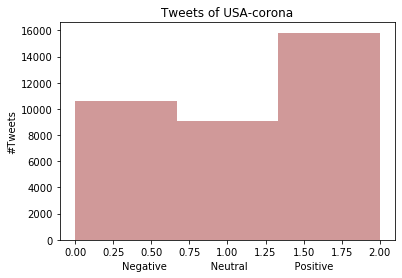

In [26]:
# Bargraph of Sentiment
sents =[]
for tw in data.Fully_cleaned_tweets:
    st = sentiment_analyzer_scores(tw)
    sents.append(st)
ax = sns.distplot(sents,kde=False,bins=3,color='darkred')
ax.set(xlabel='Negative              Neutral               Positive',ylabel='#Tweets',title="Tweets of USA-corona")

In [27]:
from collections import Counter

def con(sentence):
    emotion_list = []
    sentence = sentence.split(' ')
    with open('emotions.txt','r') as file:
        for line in file:
            clear_line = line.replace("\n", '').replace(",",'').replace("'",'').strip()
            word, emotion = clear_line.split(':')

            if word in sentence:
                emotion_list.append(emotion)
        w = Counter(emotion_list)
        return w
    

In [28]:
data['emotion'] = data['Fully_cleaned_tweets'].apply(lambda x: con(x) )

In [29]:
data.head(10)

,text,username,location,len,clean,cleant,text_Token,sentiment,Fully_cleaned_tweets,emotion
0,@FirhanM87 We have just launched a new Covid-1...,easyJet,Europe,166,We have just launched a new Covid Help Hub wh...,We launched new Covid19 Help Hub provide faste...,"[w, w, w]",2,we launched new covid help hub provide fastest...,{}
1,"The Fed is far more lethal than COVID-19… $2,0...",StanleyECook,"Athens, Al 35611",183,The Fed is far more lethal than COVID checks ...,The Fed far lethal COVID19… 2000 checks could ...,[w],0,the fed far lethal covid check could cost stag...,{}
2,🚨 @FreelandsF + @an_artnews \n\nare supportin...,myrunwaygroup,London,255,are supporting freelance creatives amp vi...,🚨 supporting freelance creatives amp visual ar...,[w],2,supporting freelance creatives amp visual arti...,{' attracted': 1}
3,RT @staronline: Covid-19: Several students tes...,Inadiasyikin,Malaysia-Singapura-Indonesia,136,Covid Several students test positive after sk...,Covid19 Several students test positive skippin...,[],2,covid several student test positive skipping s...,{}
4,A COVID-19 patient admitted to the Ahmedabad C...,VargheseGeorge8,Jaipur,217,A COVID patient admitted to the Ahmedabad Civi...,A COVID19 patient admitted Ahmedabad Civil Hos...,[],2,a covid patient admitted ahmedabad civil hospi...,{}
5,Strong Link between Coronavirus/Covid-19 and V...,HastingsSteve,Hastings,129,Strong Link between CoronavirusCovid and Vitam...,Strong Link CoronavirusCovid19 Vitamin D Defic...,[],2,strong link coronaviruscovid vitamin d deficie...,{' independent': 1}
6,Current status of COVID-19 in Malaysia as of 1...,uctsofficial,"Sibu, Sarawak, Malaysia",122,Current status of COVID in Malaysia as of May ...,Current status COVID19 Malaysia of18 May 2020 ...,[],1,current status covid malaysia may pmstayhome s...,{}
7,RT @veganfuture: Vegan diet can help prevent p...,OasisPure,"Sydney, Australia",112,Vegan diet can help prevent pandemics like CO...,Vegan diet help prevent pandemics like COVID19...,[],2,vegan diet help prevent pandemic like covid uk...,{}
8,RT @fitrasetiawan16: indonesia are fighting 2 ...,dhilbibip,"Makassar, Indonesia",124,indonesia are fighting pandemics COVID amp S...,indonesia fighting 2 pandemics COVID19 amp STU...,[],0,indonesia fighting pandemic covid amp stupidit...,{}
9,President Muhammadu Buhari on Sunday received ...,TiwatopeTemmy,Abuja,233,President Muhammadu Buhari on Sunday received ...,President Muhammadu Buhari Sunday received bri...,[],0,president muhammadu buhari sunday received bri...,{}


In [30]:
emo=con(data['Fully_cleaned_tweets'].sum())

In [31]:
data['text'][8]

'RT @fitrasetiawan16: indonesia are fighting 2 pandemics \nCOVID-19 &amp; STUPIDITY\n#TerserahIndonesia https://t.co/5SIeDKu1W5'

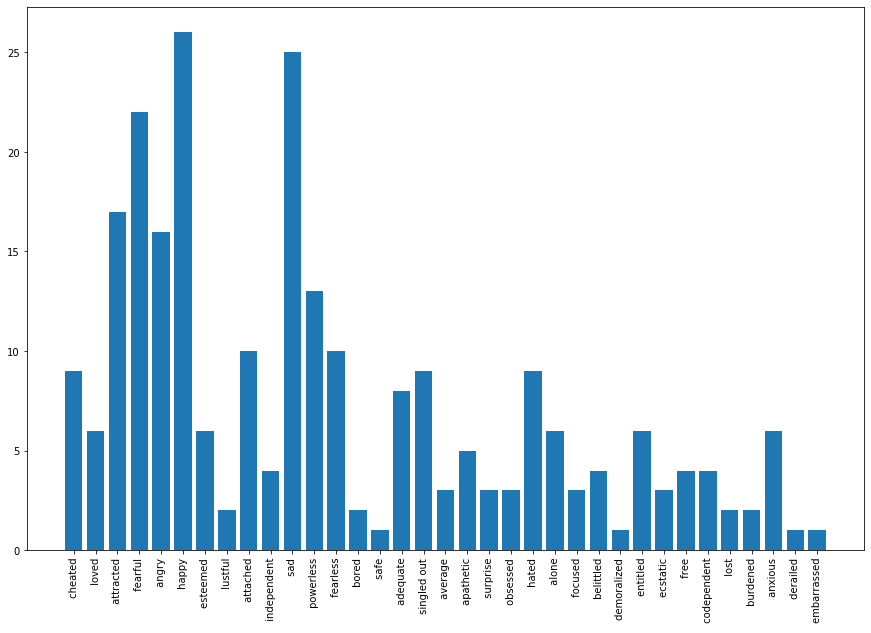

In [32]:
plt.figure(figsize = (15,10))
plt.bar(emo.keys(),emo.values())
plt.xticks(rotation = 90)
plt.show()

In [33]:
#WordCloud
def generate_wordcloud(all_words):
    Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))
    image_colors = ImageColorGenerator(Mask)
    wc = WordCloud(background_color='black', height=750, width=2000,mask=Mask).generate(all_words)
    plt.figure(figsize=(10,20))
    plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")
    plt.axis('off')
    plt.show()

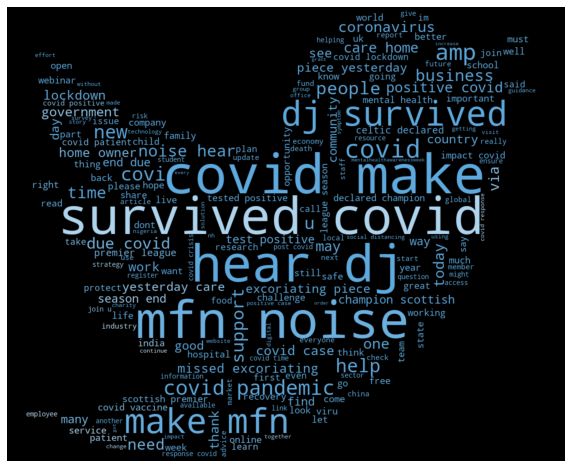

In [34]:
#WordCloud for the Positive Sentiment
all_words = ' '.join([text for text in data['Fully_cleaned_tweets'][data.sentiment == 2]])
generate_wordcloud(all_words)

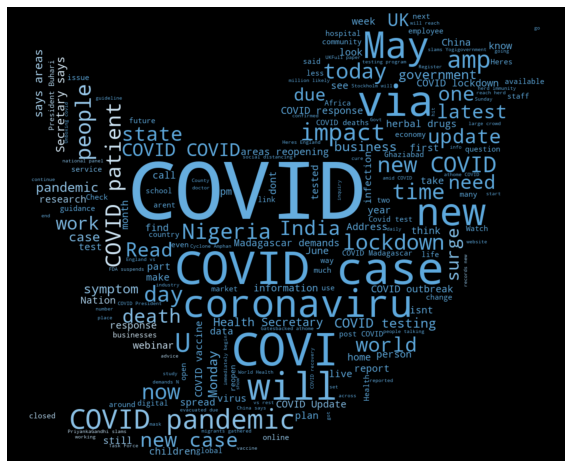

In [35]:
#WordCloud for Neutral Sentiment
all_words = ' '.join([text for text in data['clean'][data.sentiment == 1]])
generate_wordcloud(all_words)

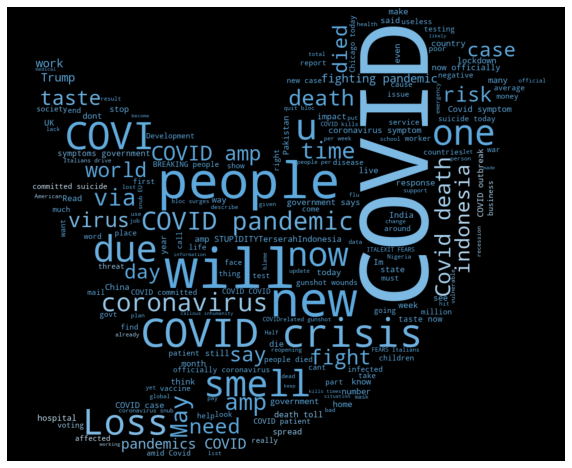

In [36]:
#Wordcloud for Negative Sentiment
all_words = ' '.join([text for text in data['clean'][data.sentiment == 0]])
generate_wordcloud(all_words)

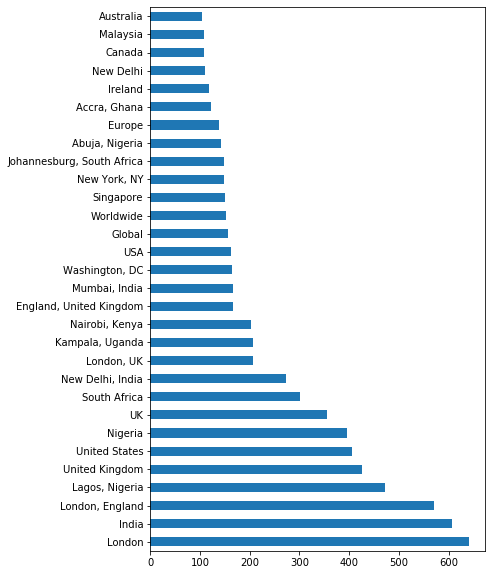

In [37]:
#Tweets Location Graph
data['location'].value_counts().head(30).plot(kind='barh', figsize=(6,10))

In [38]:
#Inserting X and Y From Dataset
x = data.iloc[:,-2].values
y = data.iloc[:,-3].values

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
x = tfidf_word_vectorizer.fit_transform(x)

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [41]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [42]:
#Validate the Model Created
predictions = classifier.predict(X_test.toarray())

In [43]:
file_name='TestTweet.csv'
test=pd.read_csv(file_name) 

In [44]:
test['clean']=clean_tweets(test['text']) 
test['clean']=test['clean'].str.replace("[^a-zA-Z ]", " ")

In [45]:
for i,tweet in enumerate(test['clean']):
    op=classifier.predict(tfidf_word_vectorizer.transform([tweet]).toarray())
    if op == [0]:
        print(i,")"," ' ",test.text[i]," ' ",'\n','=','NEGATIVE','\n')
    if op == [1]:
        print(i,")"," ' ",test.text[i]," ' ",'\n','=','NEUTRAL','\n')
    if op == [2]:
        print(i,")"," ' ",test.text[i]," ' ",'\n','=','POSITIVE','\n')

0 )  '  RT @djnicholl: Show us proof that Johnson is following science, MPs urge 

https://t.co/aN9ofVaQBV  '  
 = NEUTRAL 

1 )  '  Why people think 5G responsible for coronavirus https://t.co/jloVJuO0G0 via @YouTube  '  
 = NEUTRAL 

2 )  '  Yesterday I was walking along a pier of the #Amsterdam Oude Houthaven when an angry houseboat resident invited me leave as "they don't like walkers due to the #coronavirus" WTF...  '  
 = POSITIVE 

3 )  '  RT @WyeLea: The coronavirus crisis must not be allowed to delay Brexit https://t.co/4n6mip2MVg  '  
 = NEGATIVE 

4 )  '  #N4P #C4XD #IQAI 
Coronavirus: Moderna’s US vaccine first trials show immune response https://t.co/2vy25EMqEY  '  
 = NEUTRAL 

5 )  '  @HeshmatAlavi China knew what they were doing as soon as President Trump signed those papers. China will fulfill their deal as long as no pandemic happens. TWO days later &amp; here is Coronavirus knocking at our doors! Sue them, I say.  '  
 = NEGATIVE 

6 )  '  RT @jonworth: Even by Brexi

47 )  '  The latest on the coronavirus outbreak with Bobby @bobbyisawake &amp; Stacy @Livviesmomma -
✅DeWine: Bar owners could lose their liquor licenses if they don’t control their customers
✅Experimental vaccine shows encouraging results
✅Trump taking hydroxychloroquine https://t.co/rAhIv5Wmki  '  
 = NEGATIVE 

48 )  '  RT @RealJamesWoods: And if not, CNN will do everything it can to get us there...  https://t.co/tXG0u7XFKO  '  
 = NEUTRAL 

49 )  '  @WyeLea Agreed 100% Let's face it, we are already in a situation of a severe downturn due to the Coronavirus. The remainer argument about supply chains won't matter as we are already badly affected (for now). So we may as leave as things cannot get any worse, only much better.  '  
 = POSITIVE 

50 )  '  RT @EaterSouls: 72 people test positive for coronavirus after mass lockdown protest in Wisconsin https://t.co/CDzqAt6aAw  '  
 = POSITIVE 

51 )  '  Joining @SeneddCWLC is Nick Capaldi, Chief Executive @Arts_Wales_. Giving evidence on b

99 )  '  Cannabis extracts may help to prevent coronavirus, study suggests https://t.co/8kCRJXEIez #CannabisNews #Cannabis  '  
 = POSITIVE 

100 )  '  During these uncertain times, many of us will be worried about how we manage our rent 🏠 

We are here to help you
Talk to us 💬

The following organisations have guidance on how Coronavirus may affect income &amp; benefits ⬇️

🟡 @DWP 
🟠 @CitizensAdvice 
🟢 @YourMoneyAdvice https://t.co/VRhGlbZT4n  '  
 = POSITIVE 

101 )  '  The Government has issued an update on the symptoms of coronavirus - see below. https://t.co/TkkWJgwP1q  '  
 = NEUTRAL 

102 )  '  RT @Partisangirl: Just realise that outside of the US #Hydroxycloroquine is not a controversial drug. https://t.co/mYg3Y3Hw9E  '  
 = NEUTRAL 

103 )  '  RT @Peston: Why didn't the government protect us earlier from coronavirus? https://t.co/RslSSTYnvp  '  
 = POSITIVE 

104 )  '  @lisamurkowski Imagine the difference if Trump Republicans spent as much time on coronavirus as they do Obama

150 )  '  Trump threatens to keep WHO funding freeze in place after White House probe on early coronavirus failures https://t.co/tv37xsLtE4 #FoxNews #CNN #MSNBC  '  
 = NEGATIVE 

151 )  '  #Democrats have a plan for the #coronavirus that was started in the #UnitedStates in 2019 with #Republicans in control. #JoeBiden is the answer. 
#TrumpTrialForCoronavirusDeaths

#NancyPelosiAmericanHero https://t.co/fCvREjKzVj  '  
 = NEUTRAL 

152 )  '  #Oregon coronavirus restrictions kept in place, for now - May 19 @ 4:15 AM ET https://t.co/Pv8sry0tR1  '  
 = NEUTRAL 

153 )  '  Saturday Sunshine Drenched Beltzville Park
Friday was the first day coronavirus lockdown orders were lifted at Beltzville State Park in Carbon County, 54 miles north of Sanatoga. By Saturday, plenty of people were enjoying sunny time there.
https://t.co/fUDunSAyCl https://t.co/DjQoTFguiJ  '  
 = POSITIVE 

154 )  '  RT @wellbeingvenues: How has lockdown changed Yoga?

https://t.co/R0rgINZmYF

#yoga #coronavirus #onlineyo

203 )  '  RT @AP: Oregon Supreme Court halts judge’s order rescinding state's coronavirus stay-at-home restrictions. https://t.co/H1CjCPX6Ei  '  
 = POSITIVE 

204 )  '  RT @Pun_Starr: I think BJP leaders should most beware of Zee News journalists. Coronavirus can be transferred through boot licking.  '  
 = NEUTRAL 

205 )  '  Second https://t.co/R7Yzduz9J5. Corrections Officer Tests Positive For Coronavirus https://t.co/0JEK8Vksvc  '  
 = POSITIVE 

206 )  '  The Trump Administration Is Rushing Deportations of #Migrants Children During #Coronavirus #COVID19  https://t.co/CABU0Ahlmz  '  
 = NEGATIVE 

207 )  '  ‘The Morrison Govt’s refusal 2 extend JobKeeper 2 unis is having real consequences - regional campuses closing, hundreds of jobs lost. They could fix it with the stroke of a pen’

Staff accept voluntary redundancies as CQU struggles with $116m loss https://t.co/UbgnCuiVky  '  
 = NEGATIVE 

208 )  '  I don't think that 'let them pick spuds' is a particualatly good luck. The nas

In [46]:
#Testing Our Model

tweet="@briantylercohen Hey #Insane @realDonaldTrump $@@&% ! Are //$* you crazy? ANY of them don't need to die at all..."
clean=clean_tweets(tweet)
clean=str(clean)
clean=re.sub('[^a-zA-Z]', ' ',clean )
text=clean
clean=[clean]

In [47]:
from nltk.tokenize import RegexpTokenizer,word_tokenize
word_tokenize(text)

['Hey',
 'Insane',
 'Are',
 'you',
 'crazy',
 'ANY',
 'of',
 'them',
 'don',
 't',
 'need',
 'to',
 'die',
 'at',
 'all']

In [48]:
op=classifier.predict(tfidf_word_vectorizer.transform(clean).toarray())
if op == [0]:
    print(tweet,'\n','=','NEGATIVE','\n')
if op == [1]:
    print(tweet,'\n','=','NEUTRAL','\n')
if op == [2]:
    print(tweet,'\n','=','POSITIVE','\n')

@briantylercohen Hey #Insane @realDonaldTrump $@@&% ! Are //$* you crazy? ANY of them don't need to die at all... 
 = NEGATIVE 



In [49]:
#Accuracy Of Our Model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('Accuracy score : ',accuracy_score(y_test, predictions)*100,'\n')

Accuracy score :  83.34507538396505 



In [50]:
print(confusion_matrix(y_test,predictions),'\n')

[[1531  210  293]
 [  65 1699  193]
 [ 155  266 2685]] 



In [51]:
#saving the Prediction Model
import pickle

In [52]:
with open('Sentiment_Model','wb') as f:
    pickle.dump(classifier,f)

In [53]:
with open('Sentiment_Model','rb') as f:
    model=pickle.load(f)

In [54]:
text='chennai super kings are at the topppp of fair play award in @@@IPL 2022'
clean=clean_tweets(text)
clean=str(clean)
clean=re.sub('[^a-zA-Z]', ' ',clean )
text1=clean
clean=[clean]


In [55]:
from nltk.tokenize import RegexpTokenizer,word_tokenize
word_tokenize(text1)

['chennai',
 'super',
 'kings',
 'are',
 'at',
 'the',
 'topppp',
 'of',
 'fair',
 'play',
 'award',
 'in',
 'IPL']

In [56]:
op=classifier.predict(tfidf_word_vectorizer.transform(clean).toarray())
if op == [0]:
    print(text,'\n','=','NEGATIVE','\n')
if op == [1]:
    print(text,'\n','=','NEUTRAL','\n')
if op == [2]:
    print(text,'\n','=','POSITIVE','\n')

chennai super kings are at the topppp of fair play award in @@@IPL 2022 
 = POSITIVE 

